# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 311 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

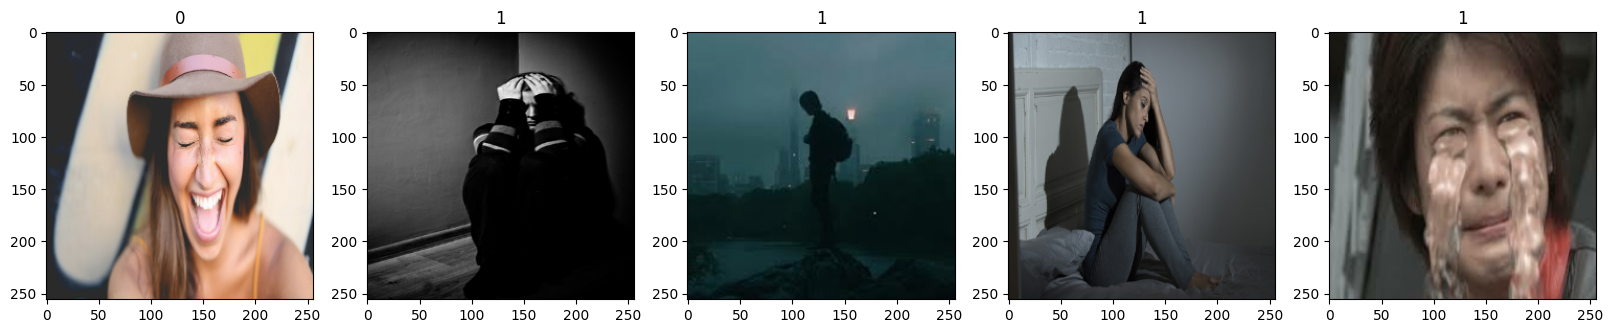

In [14]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.10196079, 0.09803922, 0.07843138],
          [0.10196079, 0.09803922, 0.07843138],
          [0.10196079, 0.09803922, 0.07843138],
          ...,
          [0.19389553, 0.1978171 , 0.17820925],
          [0.18910846, 0.19303003, 0.17342219],
          [0.17690717, 0.18082874, 0.1612209 ]],
 
         [[0.10196079, 0.09803922, 0.07843138],
          [0.10196079, 0.09803922, 0.07843138],
          [0.10196079, 0.09803922, 0.07843138],
          ...,
          [0.19389553, 0.1978171 , 0.17820925],
          [0.18910846, 0.19303003, 0.17342219],
          [0.17690717, 0.18082874, 0.1612209 ]],
 
         [[0.10196079, 0.09803922, 0.07843138],
          [0.10196079, 0.09803922, 0.07843138],
          [0.10196079, 0.09803922, 0.07843138],
          ...,
          [0.19410443, 0.198026  , 0.17841816],
          [0.18910846, 0.19303003, 0.17342219],
          [0.17690717, 0.18082874, 0.1612209 ]],
 
         ...,
 
         [[0.47984836, 0.51514244, 0.5112209 ],
          [0.48858

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

7

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [22]:
model = Sequential()

In [23]:
# First Convolution Block has 16 filters 3x3 pixels and moves 1 pixel at a time using activation map - ReLU
# The first layer needs a size for the images - 256x256 pixels with 3 channels
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# Condenses information from 2x2 blocks
model.add(MaxPooling2D())

# Another block with 32 filters
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# The last block with 16 filters
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Flattening the values into one dimention
model.add(Flatten())

# 256 output neurons for the Dense layer
model.add(Dense(256, activation='relu'))
# 1 output for the final Dense layer with sigmoid activation map - values between 0 and 1 (0=happy, 1=sad)
model.add(Dense(1, activation='sigmoid'))

In [24]:
# Compile the model with 'adam' optimizer
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 11s 1s/step - loss: 0.9824 - accuracy: 0.5045 - val_loss: 0.6957 - val_accuracy: 0.4375
Epoch 2/20
7/7 [==============================] - 10s 1s/step - loss: 0.6769 - accuracy: 0.5625 - val_loss: 0.6038 - val_accuracy: 0.7188
Epoch 3/20
7/7 [==============================] - 9s 1s/step - loss: 0.6087 - accuracy: 0.6607 - val_loss: 0.5833 - val_accuracy: 0.8281
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 0.5879 - accuracy: 0.7054 - val_loss: 0.3904 - val_accuracy: 0.9531
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 0.4444 - accuracy: 0.8482 - val_loss: 0.3402 - val_accuracy: 0.9062
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: 0.3185 - accuracy: 0.8973 - val_loss: 0.1438 - val_accuracy: 1.0000
Epoch 7/20
7/7 [==============================] - 8s 1s/step - loss: 0.1998 - accuracy: 0.9375 - val_loss: 0.1748 - val_accuracy: 0.9688
Epoch 8/20
7/7 [=====================

# 8. Plot Performance

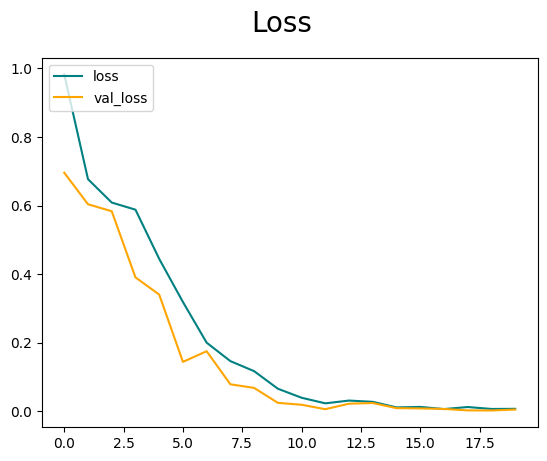

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

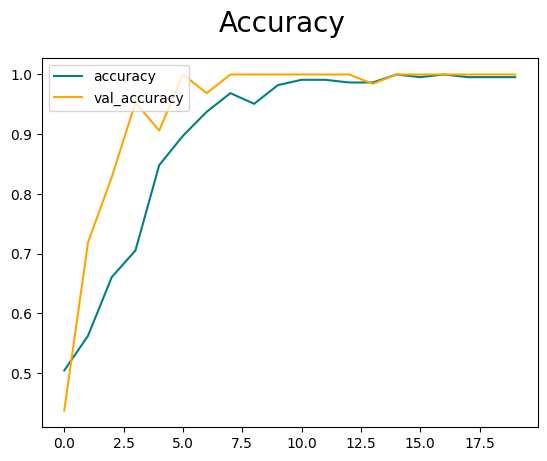

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 280ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

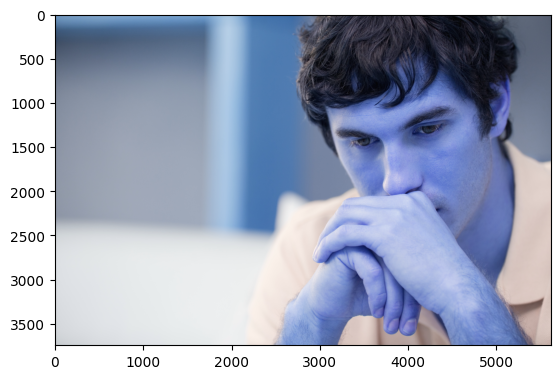

In [36]:
img = cv2.imread('data/sad/8iAb9k4aT.jpg')
plt.imshow(img)
plt.show()

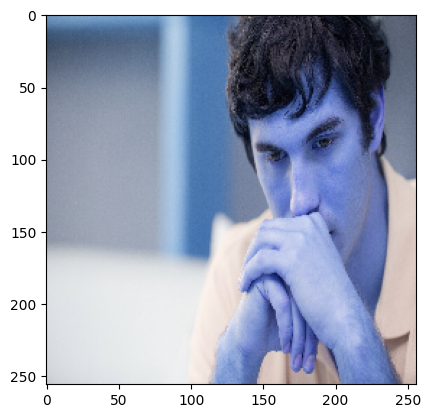

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 31ms/step


In [39]:
yhat

array([[0.9829322]], dtype=float32)

In [43]:
if yhat > 0.5: 
    print(f'Prediction is: Sad')
else:
    print(f'Prediction is: Happy')

Prediction is: Happy


# 11. Save the Model

In [41]:
model.save(os.path.join('models','cnn.h5'))

# 12. Use the saved Model without training again 

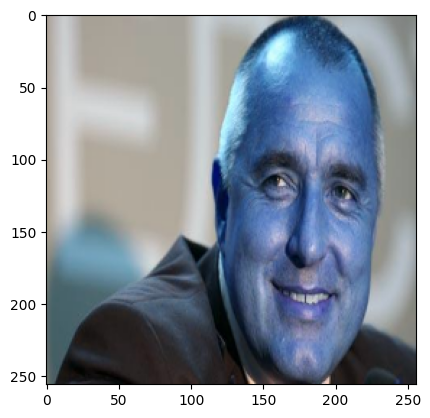

1/1 [==============================] - 0s 108ms/step
Prediction is: Happy


In [42]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
import numpy as np
import cv2

img = cv2.imread('data/happy/boyko_happy1.jpg')
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

new_model = load_model('models/cnn.h5')
yhat = new_model.predict(np.expand_dims(resize/255, 0))
if yhat > 0.5: 
    print(f'Prediction is: Sad')
else:
    print(f'Prediction is: Happy')